In [1]:
import numpy as np
import pandas as pd 

In [2]:
data = np.loadtxt("../data/logisticRegressionCircular.txt",delimiter = ",")

In [3]:
x = data[:,:2]
y = data[:,2]

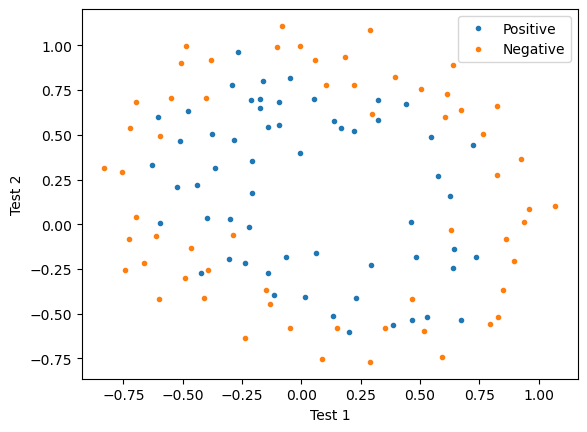

In [4]:
# 2D PLOT
import matplotlib.pyplot as plt

%matplotlib inline
plt.clf()  # clear the figure

positive = y == 1
negative = y == 0

plt.plot(x[positive, 0], x[positive, 1], '.', label="Positive")
plt.plot(x[negative, 0], x[negative, 1], '.', label="Negative")

plt.ylabel('Test 2') 
plt.xlabel('Test 1') 
plt.legend(loc="upper right")
plt.show()


In [5]:
'''
#alternate

# x_values_transformed is going to have one extra column which is the bias. You can remove it manually

from sklearn.preprocessing import PolynomialFeatures

#transforming the features using polynomial features
poly = PolynomialFeatures(degree=6)
x_values_transformed = poly.fit_transform(x)

print(x_values_transformed.shape)
'''

def map_feature(x1, x2, degree=6):
    x1 = np.atleast_1d(x1)
    x2 = np.atleast_1d(x2)
    output = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            output.append((x1**(i-j) * (x2**j)))
    return np.stack(output, axis=1)

In [6]:
mapped_x =  map_feature(x[:, 0], x[:, 1],6)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid


In [8]:
print("Before Normalization: (max, min)")
print(f"x1: ({np.max(mapped_x[:,0]):0.2f}, {np.min(mapped_x[:,0]):0.2f})")
print(f"x2: ({np.max(mapped_x[:,1]):0.2f}, {np.min(mapped_x[:,1]):0.2f})\n")

#axis = 1 -> normalize feature-wise
norm_layer = tf.keras.layers.Normalization(axis=1)
norm_layer.adapt(mapped_x) # learns mean, variance
x_normalized = norm_layer(mapped_x) #passing the data x through the normalized layer

print("After Normalization: (max, min)")
print(f"x1: ({np.max(x_normalized[:,0]):0.2f}, {np.min(x_normalized[:,0]):0.2f})")
print(f"x2: ({np.max(x_normalized[:,1]):0.2f}, {np.min(x_normalized[:,1]):0.2f})")

Before Normalization: (max, min)
x1: (1.07, -0.83)
x2: (1.11, -0.77)

After Normalization: (max, min)
x1: (2.05, -1.79)
x2: (1.79, -1.84)


In [9]:
#repeats an array along specified dimensions to create repetitions.

#
print(f"Before tiling:\nx_normalized: {x_normalized.shape}, y:{y.shape}\n")
Xt = np.tile(x_normalized,(1000,1))

Yt= np.tile(y.reshape(-1,1),(1000,1))   
print(f"After tiling:\nXt:{Xt.shape}, Yt:{Yt.shape}")   

"""
tiling our data to replicate our data, 
thereby increasing the sample size for better model training.

increasing epochs can help your model learn better but only up to a point, beyond which overfitting might occur. Data augmentation, 
such as tiling, helps improve model generalization.
"""

Before tiling:
x_normalized: (118, 27), y:(118,)

After tiling:
Xt:(118000, 27), Yt:(118000, 1)


'\ntiling our data to replicate our data, \nthereby increasing the sample size for better model training.\n\nincreasing epochs can help your model learn better but only up to a point, beyond which overfitting might occur. Data augmentation, \nsuch as tiling, helps improve model generalization.\n'

In [10]:
# Set seed for reproducibility, ensuring "random" numbers are predictable
tf.random.set_seed(15)

model = Sequential(
    [
        # Input layer to specify expected shape of the input data, (2,) in this case
        # Input: array of 27 No.s (after mapped)
        tf.keras.Input(shape=(27,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)


In [11]:

'''
Each Parameter: 32 bit (Single Precision Floating Points) -> 4 bytes
Size: 4 bytes * 88 = 352 Bytes

Input Shape: (27,)

layer1: 
3 neurons
27 * 3 = 81 weights

Each Neuron has a bias : 3 * 1 = 3 biases

81 + 3 = 84 parameters

layer2:
activation vector from layer1: (3,)
1 neuron

3 * 1 = 3 weights
Each Neuron has a bias : 1 * 1 = 1 bias

3 + 1 = 4 parameters

TOTAL: 84 parameters + 4 parameters = 88 parameters

'''

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 84        
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 88 (352.00 Byte)
Trainable params: 88 (352.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
'''
Weights: (no. of features in input, no. of neurons in the layer)
Bias: no. of neurons in a layer

layer1: 3 neurons, 2 inputs -> Weights: (2,3)
layer2: 1 neuron, 3 inputs -> Weights: (3,1)
'''

W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1 {W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1,"\n")
print(f"W2 {W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1 (27, 3):
 [[ 0.20029324 -0.12343481 -0.09001938]
 [-0.20508076  0.07544523  0.14004713]
 [ 0.42742854  0.4428789  -0.00417924]
 [ 0.18675679 -0.0701811   0.18707252]
 [ 0.08308113 -0.37236685  0.23364055]
 [ 0.31164932 -0.36557403  0.13958907]
 [ 0.41965383 -0.26825786 -0.27199578]
 [ 0.2900759   0.2870013  -0.02260152]
 [ 0.24021071  0.02498266  0.42157555]
 [ 0.03798842 -0.08188543 -0.2602862 ]
 [-0.16233018  0.00214368 -0.3428018 ]
 [ 0.40485668 -0.34784555  0.02688065]
 [-0.02176282 -0.15246436 -0.1814115 ]
 [ 0.15868342  0.30644727 -0.14244384]
 [-0.01460174  0.20764488 -0.21203382]
 [ 0.4355721  -0.18310556  0.43745548]
 [ 0.17428988 -0.22057675 -0.32644972]
 [ 0.05255371 -0.325004   -0.15717438]
 [ 0.4190218  -0.32142526 -0.00859132]
 [ 0.3979646  -0.36862677 -0.02704871]
 [-0.18018788 -0.0354237  -0.36206067]
 [-0.3027519  -0.407581    0.27620584]
 [-0.16247594  0.42308348  0.40018278]
 [-0.17222926 -0.15721893  0.04427242]
 [ 0.22067964 -0.43938068  0.12527299]
 [-0.2955957

In [13]:
#Apple Silicon: optimizers.legacy.Adam
#Base: optimizers.Adam

#BinaryCrossentropy() -> BCE -> Logistic Loss Func -> -ylog(y') - (1-y)log(1-y')
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.3),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
3688/3688 [==============================] - 2s 401us/step - loss: 0.2567
Epoch 2/10
3688/3688 [==============================] - 1s 393us/step - loss: 0.2481
Epoch 3/10
3688/3688 [==============================] - 1s 405us/step - loss: 0.2589
Epoch 4/10
3688/3688 [==============================] - 1s 396us/step - loss: 0.2541
Epoch 5/10
3688/3688 [==============================] - 1s 392us/step - loss: 0.2596
Epoch 6/10
3688/3688 [==============================] - 1s 393us/step - loss: 0.2803
Epoch 7/10
3688/3688 [==============================] - 1s 395us/step - loss: 0.2880
Epoch 8/10
3688/3688 [==============================] - 1s 393us/step - loss: 0.2967
Epoch 9/10
3688/3688 [==============================] - 1s 395us/step - loss: 0.2967
Epoch 10/10
3688/3688 [==============================] - 1s 392us/step - loss: 0.2909


In [14]:

W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1 {W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1,"\n")
print(f"W2 {W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1 (27, 3):
 [[  9.715754  -43.25331   -42.246655 ]
 [ 24.708017  -54.94965   -41.52307  ]
 [-28.387182   15.910258  -13.7245865]
 [-17.983387  125.725044   37.71061  ]
 [-11.936674   49.426594   90.07138  ]
 [ 17.499525  -11.350656  -54.683243 ]
 [  5.3950315 -89.56564    -1.8829824]
 [ -5.038196  -92.34501    10.407453 ]
 [ 12.872701  -12.018813  -38.381233 ]
 [-38.62755    50.32051    27.693422 ]
 [ -9.660671   -2.8235161  -9.331956 ]
 [-29.16026    28.616007   11.689751 ]
 [  5.291186   59.273632   15.14892  ]
 [-13.51888    26.903742   61.688927 ]
 [  8.520109    4.8383646 -35.216774 ]
 [ -0.7490812  15.509961   -5.6323233]
 [ 13.313556  -31.737427   -1.4652466]
 [-17.827211  -28.43277    -8.292692 ]
 [-14.419994   56.111076   55.933308 ]
 [  8.701893   -6.5588164 -18.936943 ]
 [-39.160202   69.01445    46.474422 ]
 [ -4.787295   -5.916827   -6.4257903]
 [-33.15789    45.229977    6.575488 ]
 [ 25.83157   -44.244617  -16.533468 ]
 [-38.46552    30.00969    63.607758 ]
 [ -4.216745

In [15]:
x_test = np.array([[0.051267,0.69956]])

# mapping the features
mapped_x_test = map_feature(x_test[:, 0], x_test[:, 1],6)

# normalizing the features
x_test_normalized = norm_layer(mapped_x_test)

print(x_test_normalized)

# reshaping using tf.reshape if necessary (the model expects input to have a certain shape)
x_test_normalized = tf.reshape(x_test_normalized, (1, -1))
# getting the prediction
y_pred = model.predict(x_test_normalized)

print(f"The model prediction for {x_test} is {y_pred[0][0]}")


tf.Tensor(
[[-0.0071013   0.99791807 -0.98977673  0.274898    0.6635931  -0.21829255
  -0.21502961  0.06425668  0.6158709  -0.5880131   0.05549109 -0.7235762
   0.24604157  0.2439574  -0.24294192 -0.16406117 -0.17240581 -0.29825962
   0.08229139  0.17403954 -0.40598637  0.01211625 -0.5542344   0.04696623
  -0.50738925  0.16502519 -0.02886213]], shape=(1, 27), dtype=float32)
1/1 [==============================] - 0s 38ms/step
The model prediction for [[0.051267 0.69956 ]] is 0.883459210395813


In [19]:
'''
#alternate (not recommended)

array = np.array([])
for m in range(x_normalized.shape[0]):
    y_pred = model.predict(np.reshape(x_normalized[m], (1, -1)))
    array = np.append(array, y_pred)
#reshape array to match the shape of y
array = array.reshape(-1, 1)
'''
array = model.predict(x_normalized)
#thresholding the probabilities
array_predictions = (array >= 0.5).astype(int)

#calculating accuracy
accuracy = np.mean(array_predictions == y.reshape(-1, 1)) * 100
print('Accuracy: %f' % accuracy)


4/4 [==============================] - 0s 788us/step
Accuracy: 88.135593


In [20]:
from tensorflow.keras.models import Model

# creating a new model that's identical to the original model up to the first layer
intermediate_model = Model(inputs=model.input, outputs=model.get_layer("layer1").output)

# for a given input x_normalized, activations of the first layer
first_layer_activations = intermediate_model.predict(x_normalized)


4/4 [==============================] - 0s 701us/step


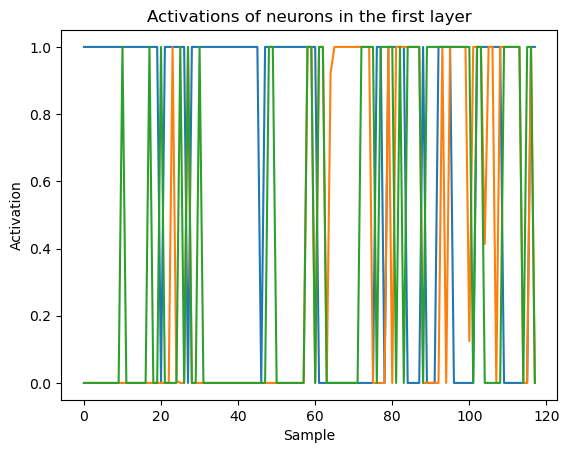

In [21]:
import matplotlib.pyplot as plt

# plotting the activations of each neuron
for i in range(first_layer_activations.shape[1]):
    plt.plot(first_layer_activations[:, i])

plt.title('Activations of neurons in the first layer')
plt.xlabel('Sample')
plt.ylabel('Activation')
#plt.legend(['Neuron 1', 'Neuron 2', 'Neuron 3'], loc='upper right')
plt.show()


4/4 [==============================] - 0s 690us/step


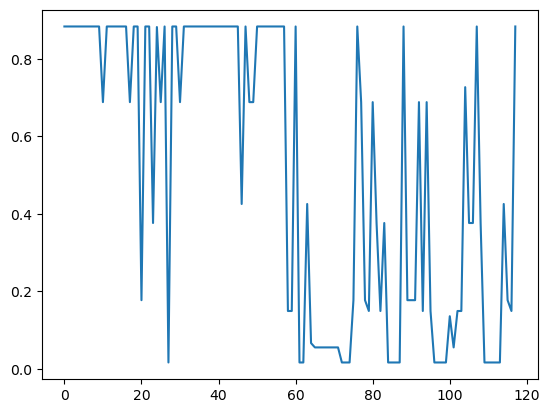

In [22]:
from keras.models import Model

# intermediate model that outputs the activations of the second layer
intermediate_model = Model(inputs=model.input, outputs=model.get_layer("layer2").output)

intermediate_output = intermediate_model.predict(x_normalized)

plt.plot(intermediate_output)
plt.show()


In [23]:
#implementing simple neural network

'''
if you multiply sigmoid(x) by e^x/e^x
sigmoid(x) = 1 / (1 + np.exp(-x)) = exp(x) / (exp(x) + 1); 

- to avoid exponent overflow in some cases
'''
def sigmoid(x):
    x = np.clip(x, -50, 50)
    # clipping the values to be within the range of -100 to 100 to avoid overflow
    return 1 / (1 + np.exp(-x))


In [24]:
def dense_layer(activation_input, w_values,b_values):
    """
    activation_input: (n,) -> reshape to (1,n)
    w_values: (n,m) -> n features per neuron, m neurons 
    b_values: (m,) -> bias vector of m units -> reshape to (1,m)
    
    activation_output: (1,m)
    
    activation_input @ w_values -> (1,n) X (n,m) = (1,m)
   """
    activation_output = sigmoid(activation_input.reshape(1,-1) @ w_values + b_values.reshape(1,-1))
    return(activation_output)
    

In [25]:
def sequential_model(X, W1, b1, w2, b2):
    a1 = dense_layer(X,  W1, b1)
    a2 = dense_layer(a1, W2, b2)
    return(a2)

In [26]:
def model_predict(X, W1, b1, W2, b2):
    m = X.shape[0]
    p = np.zeros(m)
    for i in range(m):
        p[i] = sequential_model(X[i], W1, b1, W2, b2)[0,0]
    return(p)

In [27]:
x_test = np.array([[0.051267,0.69956]])

# mapping the features
mapped_x_test = map_feature(x_test[:, 0], x_test[:, 1],6)

# normalizing the features
x_test_normalized = norm_layer(mapped_x_test)


print(x_test_normalized)

prediction = model_predict(np.array(x_test_normalized),W1,b1,W2,b2)


tf.Tensor(
[[-0.0071013   0.99791807 -0.98977673  0.274898    0.6635931  -0.21829255
  -0.21502961  0.06425668  0.6158709  -0.5880131   0.05549109 -0.7235762
   0.24604157  0.2439574  -0.24294192 -0.16406117 -0.17240581 -0.29825962
   0.08229139  0.17403954 -0.40598637  0.01211625 -0.5542344   0.04696623
  -0.50738925  0.16502519 -0.02886213]], shape=(1, 27), dtype=float32)


In [28]:
dataset_pred = model_predict(np.array(x_normalized),W1,b1,W2,b2)

In [29]:
dataset_accuracy = np.mean(dataset_pred == y.reshape(-1, 1)) * 100
print('Accuracy: %f' % accuracy)

Accuracy: 88.135593


1250/1250 [==============================] - 0s 316us/step


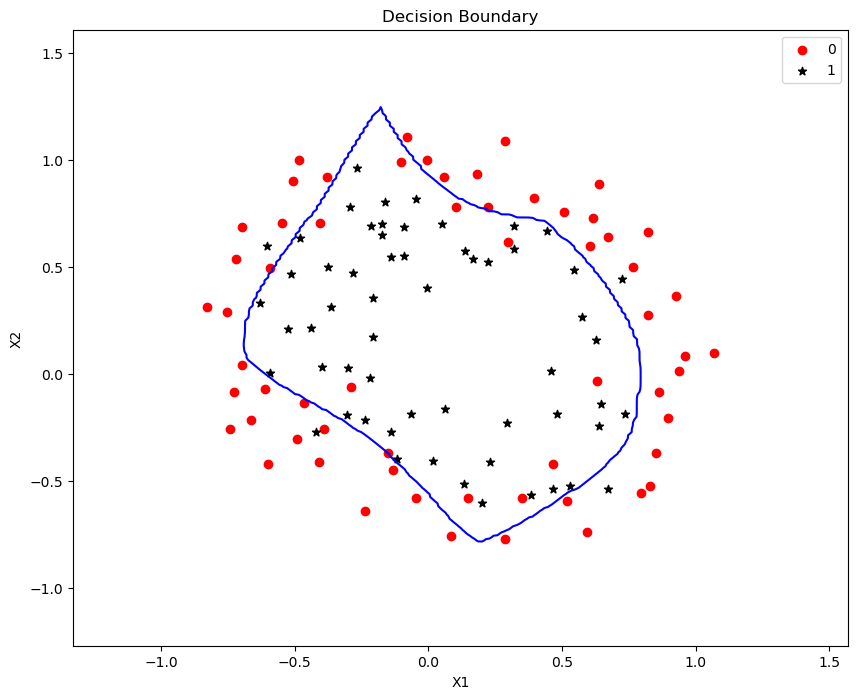

In [30]:
x1_min, x1_max = np.min(mapped_x[:,0]) - 0.5, np.max(mapped_x[:,0]) + 0.5
x2_min, x2_max = np.min(mapped_x[:,1]) - 0.5, np.max(mapped_x[:,1]) + 0.5

x1_values = np.linspace(x1_min, x1_max, 200)
x2_values = np.linspace(x2_min, x2_max, 200)

#meshgrid
x1, x2 = np.meshgrid(x1_values, x2_values)

# flattening x1 and x2 to create X_test array
X_test = np.column_stack((x1.ravel(), x2.ravel()))

# transforming X_test using map_feature function and the normalization layer
mapped_X_test = map_feature(X_test[:, 0], X_test[:, 1], 6)
normalized_X_test = norm_layer(mapped_X_test)

# using the model to predict the class of each point in the grid
Y_pred = model.predict(normalized_X_test)
# reshaping Y_pred to match the shape of the x1 and x2
Y_pred = Y_pred.reshape(x1.shape)


# Create a contour plot to show the decision boundary
plt.figure(figsize=(10, 8))
plt.contour(x1, x2, Y_pred, levels=[0.5], colors='b')  # decision boundary at p = 0.5
plt.scatter(x[y == 0, 0], x[y == 0, 1], marker='o', c='r', label="0")
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='*', c='black', label="1")
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Decision Boundary')
plt.show()


In [31]:
'''
exploring meshgrid and ravel
'''
va1s = np.linspace(1, 10, 4)
va2s = np.linspace(1, 10, 4)

v1, v2 = np.meshgrid(va1s, va2s)
print("v1:",v1,"v2:",v2,sep='\n')

print("\nv1 ravel:",v1.ravel())
print("v2 ravel:",v2.ravel())
lmno = np.column_stack((v1.ravel(),v2.ravel()))
print("\ncolumn stack:\n",lmno)

v1:
[[ 1.  4.  7. 10.]
 [ 1.  4.  7. 10.]
 [ 1.  4.  7. 10.]
 [ 1.  4.  7. 10.]]
v2:
[[ 1.  1.  1.  1.]
 [ 4.  4.  4.  4.]
 [ 7.  7.  7.  7.]
 [10. 10. 10. 10.]]

v1 ravel: [ 1.  4.  7. 10.  1.  4.  7. 10.  1.  4.  7. 10.  1.  4.  7. 10.]
v2 ravel: [ 1.  1.  1.  1.  4.  4.  4.  4.  7.  7.  7.  7. 10. 10. 10. 10.]

column stack:
 [[ 1.  1.]
 [ 4.  1.]
 [ 7.  1.]
 [10.  1.]
 [ 1.  4.]
 [ 4.  4.]
 [ 7.  4.]
 [10.  4.]
 [ 1.  7.]
 [ 4.  7.]
 [ 7.  7.]
 [10.  7.]
 [ 1. 10.]
 [ 4. 10.]
 [ 7. 10.]
 [10. 10.]]


interactive(children=(IntSlider(value=30, description='elev', max=90, step=10), IntSlider(value=120, descripti…

<function __main__.update(elev=30, azim=120)>

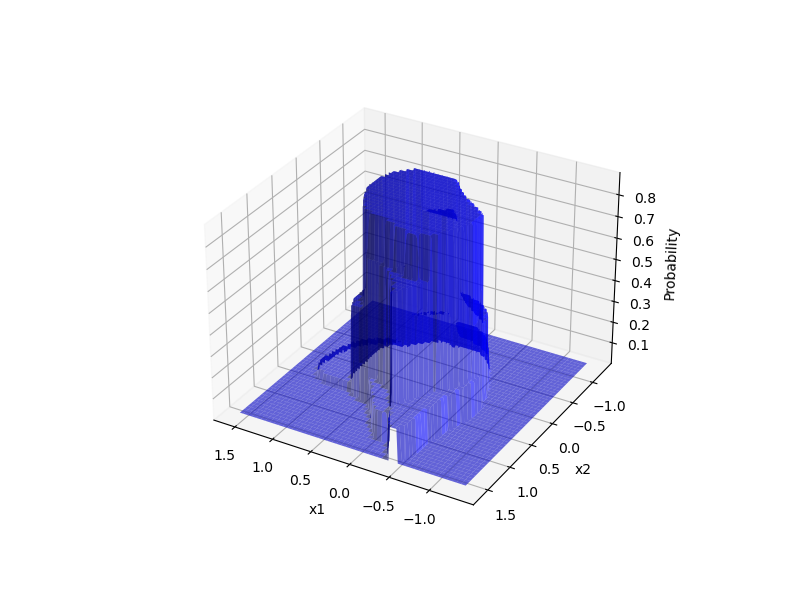

In [32]:
%matplotlib widget
'''
!pip install ipywidgets
!pip install ipympl

'''
#3D Plot
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, Y_pred, color='b', alpha=0.6)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Probability')

def update(elev=30, azim=120):
    ax.view_init(elev, azim)
    plt.draw()

interact(update, elev=(0, 90, 10), azim=(0, 360, 10))
